In [35]:
library(tidyverse,quietly = T)
library(caret,quietly = T)
library(AppliedPredictiveModeling,quietly = T)
library(Rtsne,quietly = T)
library(dplyr,quietly = T)
.libPaths("/root/R/x86_64-conda_cos6-linux-gnu-library/3.5")
library(cluster,quietly = T)
library(fpc,quietly = T)
library(caret,quietly = T)
require(randomForest,quietly = T)
library(ROCR,quietly = T)
library(reshape,quietly = T)
library(ggpubr,quietly = T)
library(gridExtra,quietly = T)

<a id='TOC'></a>

# Direct Links to Plots and Results


<a href='#plot1'>1. tSNE plot for all case control samples from 6 cancer types</a>

<a href='#plot2'>2. tSNE plot for all case control samples from 6 cancer types [Averaged] by probes in ESS/SIV</a>

<a href='#plot3'>3. tSNE plot for PC Cases and Controls</a>

<a href='#plot4'>4. tSNE plot for PC Cases and Controls (Seperated) </a>

<a href='#plot5'>5. Cluster PC Cases using tSNE and Extract them using DBSCAN </a>

<a href='#PLS_PC_clusters'>6. Variables Selected by PLS (Partial Least Squares) Algorithm </a>

<a href='#plot6'>7. VTRNA2-1 and DUSP22 Scatter plot for case and controls (started with cases) </a>

<a href='#plot7'>8. VTRNA2-1 and DUSP22 Scatter plot for case and controls (started with controls) </a>

<a href='#plot8'>9. Breast Cancer Cases (tSNE plot) </a>

<a href='#plot9'>10. CRC Cases (tSNE plot)</a>

<a href='#plot10'>11. Lung Cancer Cases(tSNE plot) </a>

<a href='#plot11'>12. MBCN Cases (tSNE plot)</a>

<a href='#plot12'>13. UCC Cases (tSNE plot)</a>

# Unsupervised clustering of MCCS Cancer cohort DNA methylation data

### Loading MCCS data

In [5]:
mccs_ess <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ess_mccs_data.csv",stringsAsFactors=FALSE)
dim(mccs_ess)
ess_siv_probs <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/ESS_SIV_Probes.csv")
dim(ess_siv_probs)
table(mccs_ess$CancerCellType)
head(mccs_ess)

[1] 6926 3836

[1] 2210   31


    BC    CRC Kidney   Lung   MBCN     PC    UCC 
   866   1668    282    662    870   1726    852 

Sample,CancerCellType,AlcoholAmount,CaseControl,ID,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,cg27532845,cg27544046,cg27571329,cg27582696,cg27592331,cg27619291,cg27625491,cg27631256,cg27652490,cg27662789
Sample_1,BC,4,0,BC_Pair_1,0,0.08745385,29.20516,0.10727967,0.14815719,⋯,2.280988,2.795142,3.338043,0.2757069,-3.337371,NA,2.4544216,-4.468435,3.074308,1.5031854
Sample_2,BC,2,1,BC_Pair_1,0,0.10287884,27.96231,0.13150276,0.12602529,⋯,4.014220,1.086616,9.964341,NA,-4.822580,NA,0.8084884,-7.693036,4.349528,0.2663663
Sample_3,BC,2,1,BC_Pair_2,-1,0.09067746,21.87242,0.04251249,0.17096309,⋯,2.187318,2.341161,5.138541,1.6337358,-3.616787,NA,5.5207225,-4.831125,3.901991,-0.1687805
Sample_4,BC,2,0,BC_Pair_2,-1,0.10010919,23.83473,0.08627580,0.13397215,⋯,2.537392,2.546065,4.042145,-0.3903966,-4.159341,NA,2.8802368,-6.559135,3.913823,0.8703156
Sample_5,BC,2,0,BC_Pair_3,-1,0.08467049,23.55767,0.03608380,0.09226610,⋯,1.139770,3.296778,3.428133,5.1884724,-4.835844,NA,2.7962156,-3.413570,4.278615,-0.1579524
Sample_6,BC,2,1,BC_Pair_3,0,0.05459091,34.10303,0.05873613,0.06257519,⋯,1.908921,2.766869,3.602330,5.7284437,-3.555191,NA,2.9473541,-5.424312,3.678586,-0.3242363


### Loading ESS_SIV_probs

In [6]:
head(ess_siv_probs)
probeIDs <-ess_siv_probs[c("CG","UCSC.browser.coordinates")]
select_columns <- c('CancerCellType','AlcoholAmount', 'CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')
cancer_cases <- mccs_ess#[mccs_ess$CaseControl!=1,]
myvars <- names(cancer_cases) %in% c('Sample','ID','AlcoholAmount','CaseControl','Smoking','bcell','bmi_rrto','cd4t','cd8t','gran','mono','nk')
cancer_cases_methy <- cancer_cases[!myvars]
cancer_cases_methy_ESS_SIV <- cancer_cases_methy[,ess_siv_probs$CG]
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV[ , !(names(cancer_cases_methy_ESS_SIV) %in% c("CancerCellType"))]
nums <- unlist(lapply(cancer_cases_methy_ESS_SIV_cg, is.numeric))
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[,nums]
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[ , colSums(is.na(cancer_cases_methy_ESS_SIV_cg)) == 0]
dim(cancer_cases_methy_ESS_SIV_cg)

UCSC.browser.coordinates,Chr,Start,End,CG,ESS.hit,SIV.hit,Shi.et.al..substantial.mQTL,Grundberg.et.al..conservative.mQTL,Volkov.et.al..mQTL,⋯,GE1.Distance,GE2.Symbol,GE2.Description,GE2.Distance,GE3.Symbol,GE3.Description,GE3.Distance,Bin.Intragenic.to.Genes,No.Gene.Assoc.,Assoc..Gene
chr1:839752-839753,chr1,839752,839753,cg23733394,TRUE,TRUE,FALSE,FALSE,TRUE,⋯,NA,NA,NA,NA,NA,NA,NA,,TRUE,0
chr1:1225781-1225782,chr1,1225781,1225782,cg18224942,TRUE,FALSE,FALSE,TRUE,FALSE,⋯,-1628,ACAP3,"arf-GAP with coiled-coil, ANK repeat and PH domain-containing protein 3",1982,NA,NA,NA,SCNN1D,FALSE,SCNN1D
chr1:1265354-1265355,chr1,1265354,1265355,cg16590012,TRUE,FALSE,FALSE,TRUE,TRUE,⋯,1078,NA,NA,NA,NA,NA,NA,,FALSE,TAS1R3
chr1:1380621-1380622,chr1,1380621,1380622,cg18148498,TRUE,FALSE,FALSE,TRUE,FALSE,⋯,2359,NA,NA,NA,NA,NA,NA,,FALSE,VWA1
chr1:1571801-1571802,chr1,1571801,1571802,cg27541892,TRUE,FALSE,FALSE,FALSE,FALSE,⋯,-1199,MMP23B,matrix metalloproteinase-23 precursor,1771,MMP23A,,1774,CDK11B,FALSE,CDK11B
chr1:1586880-1586881,chr1,1586880,1586881,cg17450090,TRUE,FALSE,FALSE,FALSE,FALSE,⋯,NA,NA,NA,NA,NA,NA,NA,CDK11B,FALSE,CDK11B


[1] 6926 1266

* Extract only DNA methylation in the data

In [8]:
dim(cancer_cases_methy_ESS_SIV_cg)
head(cancer_cases_methy_ESS_SIV_cg)

[1] 6926 1266

cg03492136,cg25769590,cg23649088,cg25602718,cg03074188,cg00819233,cg07234876,cg11634705,cg20300514,cg14604444,⋯,cg18709881,cg05017628,cg13582457,cg20296298,cg14291745,cg20583945,cg19431051,cg20607798,cg03188948,cg21918786
3.411191,0.3822916,2.1757273,4.213013,-1.958672,4.060164,5.3389623,1.852355,-1.6834712,4.287286,⋯,2.1428118,4.233406,2.926465,1.2589967,1.7678588,-0.2839182,3.284021,-1.169833,-0.3630766,4.745145
3.973023,1.1548943,0.7106642,2.811810,-1.580402,2.353017,4.6335278,4.319033,-2.1600873,5.750615,⋯,2.8447886,4.493586,3.202899,3.6718182,3.1288862,-1.3103998,2.459790,-1.644860,-2.0396962,3.912505
3.687891,2.1327854,-1.2254206,2.147111,-1.327944,5.031538,4.2166206,1.955170,-0.9040569,5.336784,⋯,0.4078471,6.441207,3.074330,3.2784648,1.5891772,-2.2147559,1.948411,-2.678422,-2.6976487,3.503785
3.903715,2.1439821,2.1044508,1.369702,-1.279448,4.434092,0.8554057,2.388811,-2.4683870,2.066065,⋯,2.2100882,5.088514,2.677094,2.5855644,0.6229873,-1.2465905,2.434109,-1.965128,-3.6314047,2.654273
4.069919,0.3436572,0.7248394,2.247164,-1.477084,4.786576,3.8492824,1.919371,-2.4758154,5.836336,⋯,0.6423293,1.609661,2.295007,0.8383845,1.2076220,-2.4670080,1.349044,-3.528800,-2.5553984,3.052435
3.742138,0.2471657,0.5492002,1.186777,-1.912100,4.960848,3.8617064,1.915906,-2.3696653,2.765883,⋯,0.7441665,1.164236,3.665103,2.9720365,-0.1209216,-1.8391323,1.516913,-2.683873,-0.8430263,2.127156


### t-SNE (t-distributed stochastic neighbour embedding) : A technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets
<a href='#TOC'>Go to TOC</a>
<a id='plot1'></a>


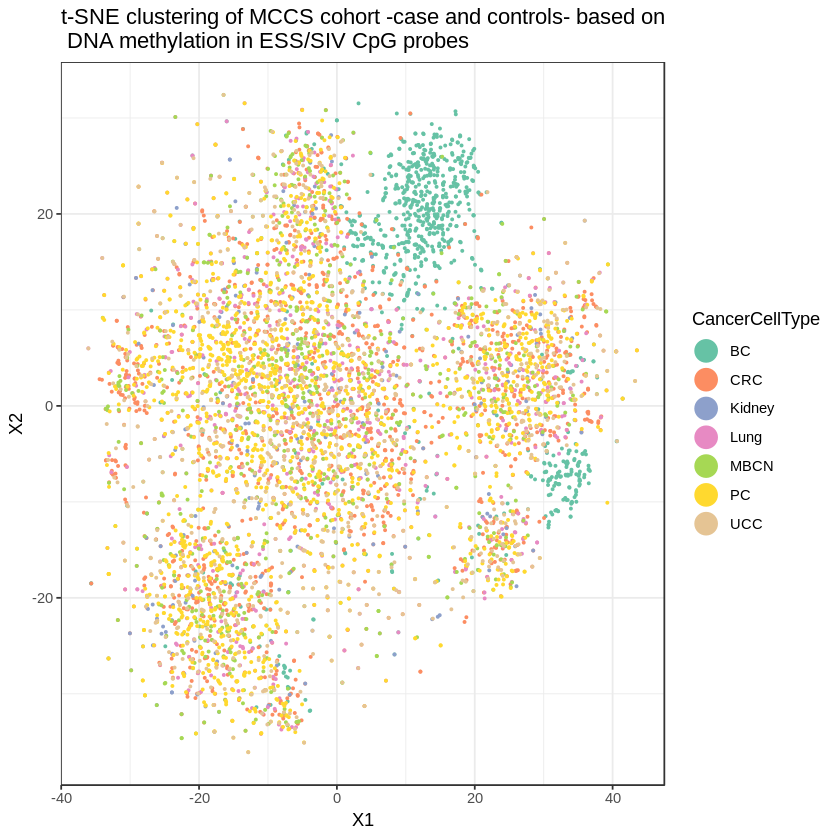

In [9]:

tsne_model_1 = Rtsne(as.matrix(cancer_cases_methy_ESS_SIV_cg), check_duplicates=T, pca=T, perplexity=20, theta=0.5, dims=2)
d_tsne_1 = as.data.frame(tsne_model_1$Y)
d_tsne_1$CancerCellType <- cancer_cases_methy_ESS_SIV$CancerCellType

ggplot(d_tsne_1, aes(x=V1, y=V2,colour = CancerCellType)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("X1") + ylab("X2") +theme_bw()+
  ggtitle("t-SNE clustering of MCCS cohort -case and controls- based on \n DNA methylation in ESS/SIV CpG probes") +
  scale_colour_brewer(palette = "Set2")


<a href='#TOC'>Go to TOC</a>

### After averaging probes withing each ESS/SIV cluster

The ESS_SIV clusters contain multiple CpG probs. The DNA methylation data as averaged accros each cluster.To see if this dataset has the same signal. The tSNE was done the same way on this dataset.

In [10]:
mccs_ess_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")

In [11]:
head(mccs_ess_avg)

Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
Sample_1,BC,0,BC_Pair_1,4,0,0.08745385,29.20516,0.10727967,0.14815719,⋯,1.90055724,-0.172131130,-0.98136321,-0.37835463,0.4677048,3.418657,2.2788181,-4.111436,-2.37729239,-0.6662078
Sample_2,BC,1,BC_Pair_1,2,0,0.10287884,27.96231,0.13150276,0.12602529,⋯,1.99247432,-0.377134561,3.99502545,-2.13995498,2.4609309,2.243908,0.5364608,-4.387155,0.34371430,-0.1857028
Sample_3,BC,1,BC_Pair_2,2,-1,0.09067746,21.87242,0.04251249,0.17096309,⋯,1.39138196,0.150830974,-0.08597206,0.05488047,0.7671964,4.169128,1.8769565,-4.050547,-0.25642456,-1.1704468
Sample_4,BC,0,BC_Pair_2,2,-1,0.10010919,23.83473,0.08627580,0.13397215,⋯,2.05991049,-0.039849101,0.24012048,-1.09355985,3.1355813,3.565403,0.4075999,-4.249466,0.08080532,0.2184171
Sample_5,BC,0,BC_Pair_3,2,-1,0.08467049,23.55767,0.03608380,0.09226610,⋯,0.05257601,-0.052262948,0.58533440,-0.92471476,-0.3802198,2.828289,0.6752125,-4.515023,0.32588108,-1.0060959
Sample_6,BC,1,BC_Pair_3,2,0,0.05459091,34.10303,0.05873613,0.06257519,⋯,1.51852631,0.007166724,-0.05079584,-1.68766306,0.2811630,2.977444,1.5702150,-4.114159,-3.24256129,-1.6433150


In [12]:
data_mccs_ess_avg <-subset(mccs_ess_avg,select = -c(Sample,CancerCellType,CaseControl,ID,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))

In [13]:
head(data_mccs_ess_avg)

ACADM,ADGRD1,AGPAT4,ANKDD1B,ANKRD20A11P,ANKRD30B,ATP11A,C17orf98,C1orf86,C22orf34,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
-0.7015962,1.303992,4.0285859,0.009686569,-0.68978079,-0.8138972,-0.8130793,0.6439624,-1.5734017,0.21528258,⋯,1.90055724,-0.172131130,-0.98136321,-0.37835463,0.4677048,3.418657,2.2788181,-4.111436,-2.37729239,-0.6662078
-1.5742368,1.897934,5.4150429,0.425302932,-0.37398061,-2.2185285,-0.8060041,0.2699102,-1.1954092,0.54809465,⋯,1.99247432,-0.377134561,3.99502545,-2.13995498,2.4609309,2.243908,0.5364608,-4.387155,0.34371430,-0.1857028
-0.5006276,1.632135,0.8290209,0.653712273,-0.06624538,-0.9158305,0.4992603,1.7063610,-0.4513314,1.00085304,⋯,1.39138196,0.150830974,-0.08597206,0.05488047,0.7671964,4.169128,1.8769565,-4.050547,-0.25642456,-1.1704468
0.6202377,2.377178,4.3738864,0.269818539,0.35549330,-1.4121966,0.2559579,1.0542470,-1.1702811,2.85620427,⋯,2.05991049,-0.039849101,0.24012048,-1.09355985,3.1355813,3.565403,0.4075999,-4.249466,0.08080532,0.2184171
-0.8404002,3.138574,4.9940198,0.868241469,-1.31002241,-0.7276339,-1.1927664,0.4381603,-1.7278624,2.82841966,⋯,0.05257601,-0.052262948,0.58533440,-0.92471476,-0.3802198,2.828289,0.6752125,-4.515023,0.32588108,-1.0060959
-0.6943310,3.694683,0.8220768,-0.249635507,-1.06688765,-2.4352753,-0.2803052,0.3651501,-1.7021914,-0.06967963,⋯,1.51852631,0.007166724,-0.05079584,-1.68766306,0.2811630,2.977444,1.5702150,-4.114159,-3.24256129,-1.6433150


<a id='plot2'></a>
<a href='#TOC'>Go to TOC</a>

[1] 6926 2210

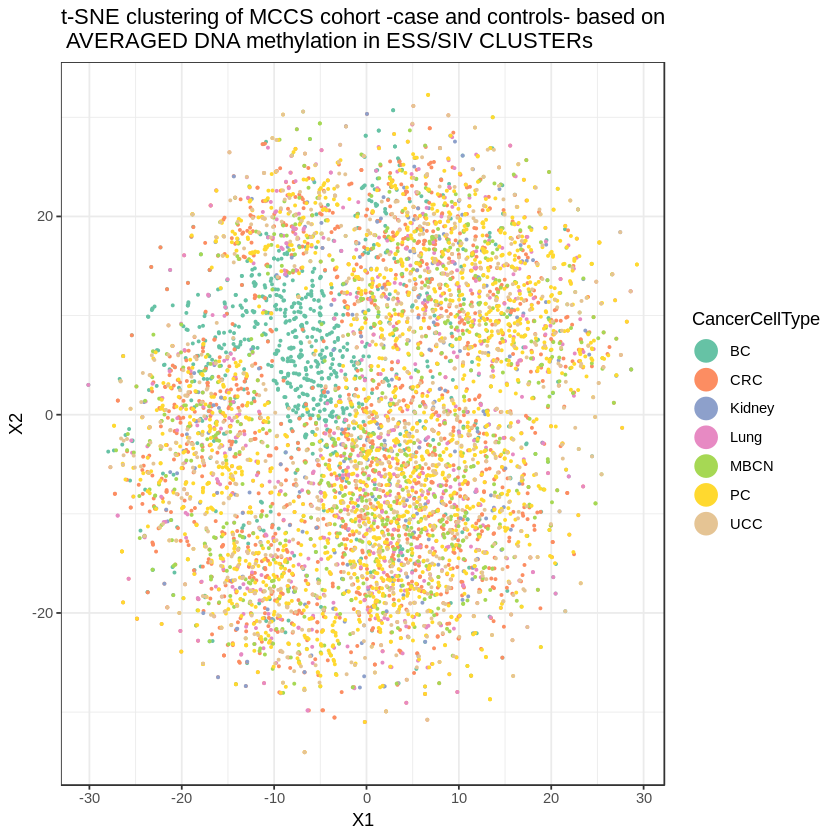

In [30]:
tsne_model_2 = Rtsne(as.matrix(data_mccs_ess_avg), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_2 = as.data.frame(tsne_model_2$Y)
d_tsne_2$CancerCellType <- mccs_ess_avg$CancerCellType
nums <- unlist(lapply(cancer_cases_methy_ESS_SIV_cg, is.numeric))
cancer_cases_methy_ESS_SIV_cg <- cancer_cases_methy_ESS_SIV_cg[,nums]
dim(cancer_cases_methy_ESS_SIV)
ggplot(d_tsne_2, aes(x=V1, y=V2,colour = CancerCellType)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("X1") + ylab("X2") +theme_bw()+
  ggtitle("t-SNE clustering of MCCS cohort -case and controls- based on \n AVERAGED DNA methylation in ESS/SIV CLUSTERs") +
  scale_colour_brewer(palette = "Set2")

<a href='#TOC'>Go to TOC</a>

# tSNE Clustering Within Each Cancer Type


## 1. Prostate Cancer: Can we cluster cases and controls seperately with DNA methylation data in ESS/SIV?
<a href='#TOC'>Go to TOC</a>
<a id='plot3'></a>

In [22]:
cancer_cases_controls <- mccs_ess[mccs_ess$CancerCellType=='PC',]
cancer_cases_control_methy<- cancer_cases_controls[,ess_siv_probs$CG]
dim(cancer_cases_control_methy)
nums <- unlist(lapply(cancer_cases_control_methy, is.numeric))
cancer_cases_control_methy <- cancer_cases_control_methy[,nums]
cancer_cases_control_methy <- cancer_cases_control_methy[ , colSums(is.na(cancer_cases_control_methy)) == 0]
dim(cancer_cases_control_methy)

[1] 1726 2210

[1] 1726 1636

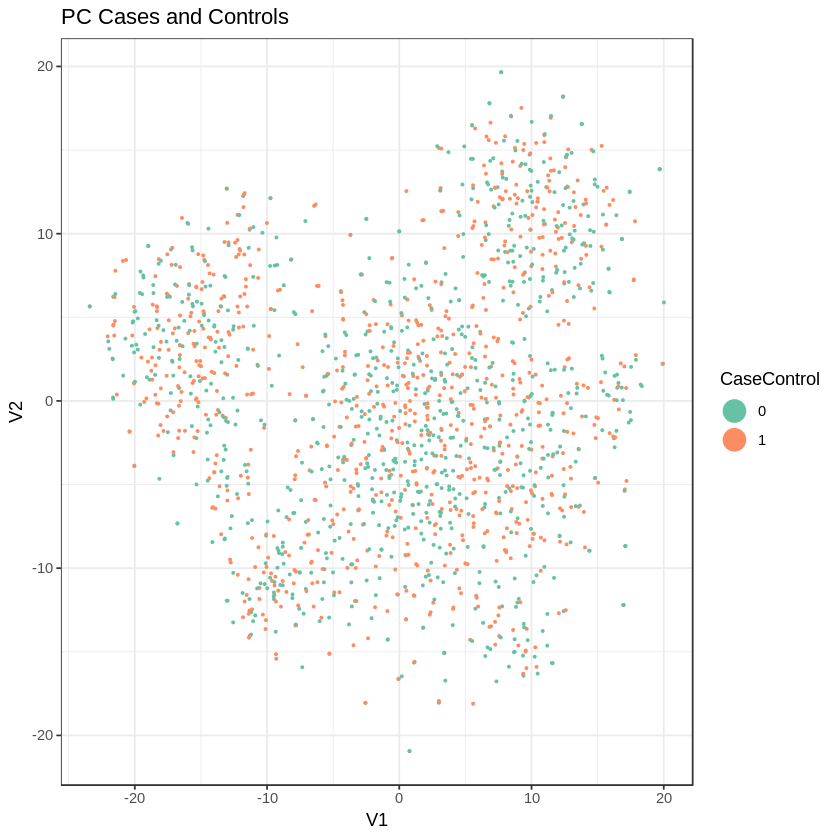

In [29]:
set.seed(9)
tsne_model_PC_case_control = Rtsne(as.matrix(cancer_cases_control_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
tsne_model_PC_case_control = as.data.frame(tsne_model_PC_case_control$Y)
tsne_model_PC_case_control$CaseControl <- as.factor(cancer_cases_controls$CaseControl)
ggplot(tsne_model_PC_case_control, aes(x=V1, y=V2,colour=CaseControl)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("PC Cases and Controls") +
  scale_colour_brewer(palette = "Set2")

<a href='#TOC'>Go to TOC</a>
<a id='plot4'></a>

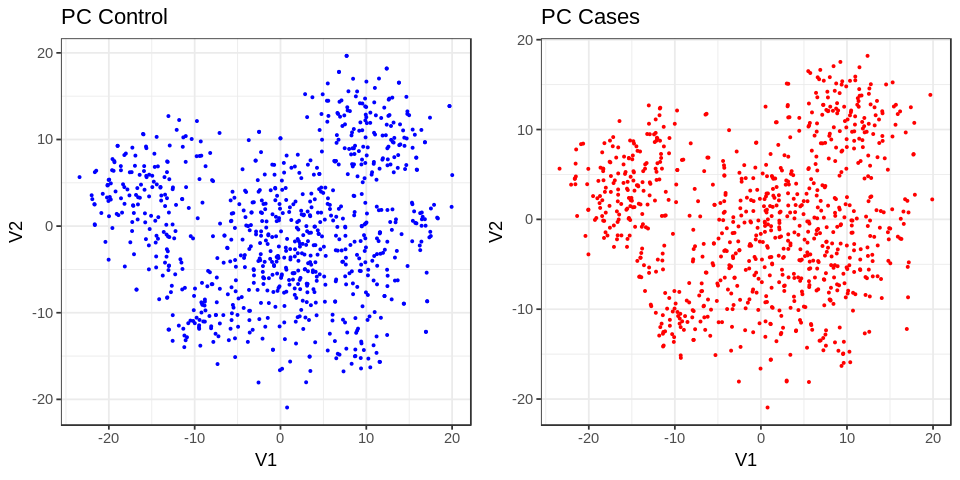

In [50]:
case <- ggplot(tsne_model_PC_case_control[tsne_model_PC_case_control$CaseControl==1,], aes(x=V1, y=V2)) +
  geom_point(size=0.45,color="red") +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("PC Cases") +
  scale_colour_brewer(palette = "Set2")
control <- ggplot(tsne_model_PC_case_control[tsne_model_PC_case_control$CaseControl==0,], aes(x=V1, y=V2)) +
  geom_point(size=0.45,color="blue") +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("PC Control") +
  scale_colour_brewer(palette = "Set2")
options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(control, case, ncol=2,nrow=1)

<a href='#TOC'>Go to TOC</a>

**Since it appears there are no clear seperation between PC case and controls we tried looking at each cluster of PC cases and its matching controls**

## Which variables drive the classification between each cluster of Cases and its matching controls

## We used the following procedure to do that:

### 1. Cluster PC Cases using tSNE and Extract them using DBSCAN
<a href='#TOC'>Go to TOC</a>
<a id='plot5'></a>

[1]  863 2210

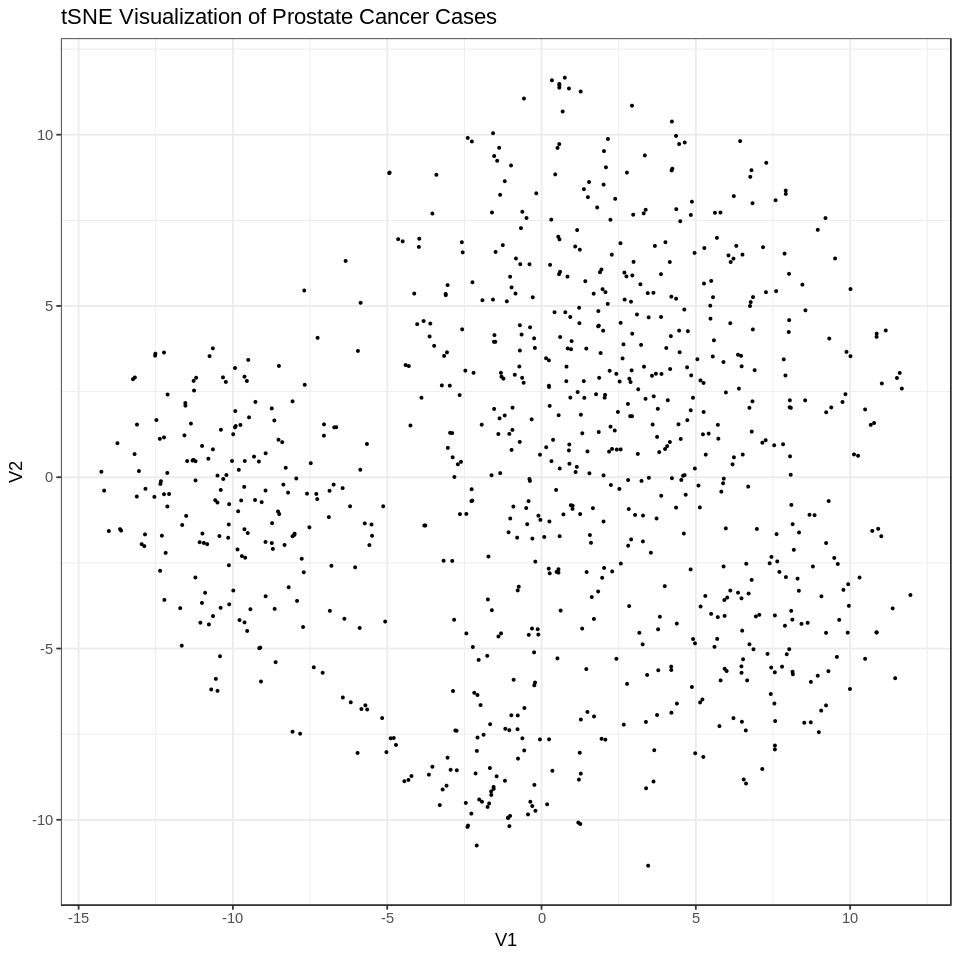

DBSCAN clustering for 863 objects.
Parameters: eps = 1.5, minPts = 15
The clustering contains 3 cluster(s) and 106 noise points.

  0   1   2   3 
106 474 116 167 

Available fields: cluster, eps, minPts

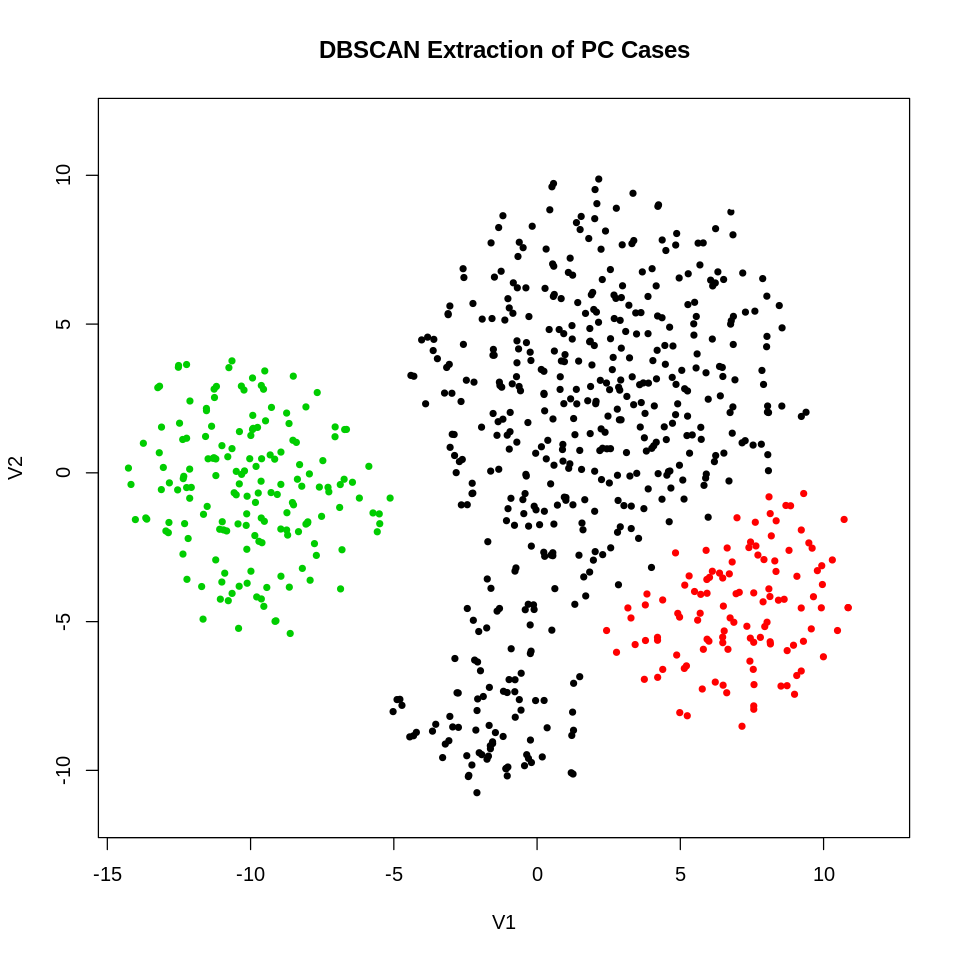

In [59]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_control <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]#cluster based on cases

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)
options(repr.plot.width=8, repr.plot.height=8)
ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("tSNE Visualization of Prostate Cancer Cases") +
  scale_colour_brewer(palette = "Set2")
res <- dbscan::dbscan(d_tsne_3,eps = 1.5, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC Cases")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

<a href='#TOC'>Go to TOC</a>
### 2. Extract case clusters, bring in matching controls and create three dataframes for each cluster
* Rest of the analysis is done with averaging probes within each ESS/SIV

In [66]:
d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3)
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")
cancer_cases_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==1,]
cancer_controls_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==0,]

cluster1_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster3$ID,]



cluster1_data <- rbind(cluster1_cases,cluster1_controls)
cluster1_data <- subset(cluster1_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_data$CaseControl <- as.factor(cluster1_data$CaseControl)
print("cluster1")
head(cluster1_data)
tail(cluster1_data)

cluster2_data <- rbind(cluster2_cases,cluster2_controls)
cluster2_data <- subset(cluster2_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster2_data$CaseControl <- as.factor(cluster2_data$CaseControl)


cluster3_data <- rbind(cluster3_cases,cluster3_controls)
cluster3_data <- subset(cluster3_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster3_data$CaseControl <- as.factor(cluster3_data$CaseControl)

cluster1_data$cluster <- rep("C1",dim(cluster1_data)[1])
cluster2_data$cluster <- rep("C2",dim(cluster2_data)[1])
cluster3_data$cluster <- rep("C3",dim(cluster3_data)[1])

all_cluster_data <- rbind(cluster1_data,cluster2_data,cluster3_data)


V1,V2,cluster,ID
-1.3959189,-4.6476141,1,PC_Pair_1
-14.2628937,0.1604518,3,PC_Pair_2
3.5794374,2.9629831,1,PC_Pair_3
5.9716910,-1.4912276,1,PC_Pair_4
6.3676282,3.5761073,1,PC_Pair_5
0.5680226,5.9295431,1,PC_Pair_6


[1] "cluster1"


,CaseControl,ACADM,ADGRD1,AGPAT4,ANKDD1B,ANKRD20A11P,ANKRD30B,ATP11A,C17orf98,C1orf86,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
4350,1,0.7041977,2.748498,4.464242,-0.50715770,-0.1474585,-1.1737426,0.7528380,0.2624415,-0.02127049,⋯,1.2262072,0.8556876,1.0768256,-0.9672918,2.2953312,3.557203,1.5330157,-1.744068,0.5329113,0.968932779
4353,1,-1.4860289,3.089721,4.407704,-2.10061730,0.9917779,-0.3428516,0.1658720,0.4118937,-0.03323769,⋯,1.6851114,0.1400600,0.6258309,-0.1437234,3.1403654,2.954671,1.9219780,-3.259399,0.1057944,0.002889846
4355,1,1.0640191,2.772772,4.336310,0.06101848,-0.7394669,-1.5199955,-0.8040751,0.7426801,0.19885249,⋯,2.4120595,0.5453855,0.7982160,-0.9299917,3.1558635,3.003048,0.5877212,-2.936598,0.8860706,0.326238155
4358,1,-0.7797309,4.232276,4.375271,0.04588203,1.7076729,-2.3415597,-0.2065008,0.8482111,-0.27742300,⋯,2.2369826,0.5265385,0.8642715,-0.5512491,0.8518819,3.064723,-0.9403711,-3.147413,-3.2661796,-1.392128455
4360,1,-1.6417493,1.498153,4.223492,0.64674808,-0.4656938,-1.1586481,-0.6738730,0.3928819,0.12572105,⋯,-0.4110105,0.4845656,0.7149950,-0.7424551,1.6664075,2.882332,1.9814976,-3.757477,0.7106879,0.289179001
4364,1,0.1572353,2.428494,4.562383,0.41838765,-0.8953319,-1.1280747,1.1801281,0.7845050,1.18647453,⋯,2.3224883,0.5681482,0.4236015,0.8411062,1.1290718,3.737171,0.5636090,-1.874462,-2.6261978,-0.093592184


,CaseControl,ACADM,ADGRD1,AGPAT4,ANKDD1B,ANKRD20A11P,ANKRD30B,ATP11A,C17orf98,C1orf86,⋯,VIPR2,VTRNA2.1,WDR27,WDR90,ZFP57,ZFYVE28,ZNF251,ZNF681,ZNF714,ZNF890P
6054,0,-0.8310152,3.669183,4.641041,0.2918084,-0.5662285,-1.3601262,-0.2706660,0.2167719,-0.3096635,⋯,2.2119311,0.7147486,0.4709459,0.13069083,3.042402,3.432317,1.2627700,-2.7403216,0.9555435,-0.3232495
6056,0,-0.6597585,2.383077,4.801218,-0.9867414,-0.5600934,-1.3665431,-0.2253871,0.2669697,-0.2292898,⋯,0.9615049,0.4501761,0.7474924,0.03856768,2.829578,3.392321,1.8435825,-2.8473263,-0.6623985,0.2628692
6058,0,-1.5761747,3.317423,1.299717,1.6273720,-0.7068102,-0.7943199,-0.3389463,1.1551403,-0.2257405,⋯,2.8430812,-2.8656249,0.8227487,0.20620827,1.842553,3.011938,1.8347738,-1.8821346,0.3560686,0.1845637
6068,0,-0.7959437,2.247649,4.796341,0.7927585,-0.4063891,-1.0691840,0.5919576,0.3229408,-0.3886673,⋯,2.3514948,-3.2904889,0.8775376,0.23044691,3.384130,3.425435,-0.9562916,-2.9148745,-0.7962317,-0.1467027
6071,0,-0.4174926,2.194338,4.170426,2.4371842,0.1222008,-1.0106285,0.5042132,0.4340315,-0.6999828,⋯,1.9754478,0.6071276,0.9931520,0.10507590,1.279315,3.422737,0.8671951,-0.1865923,0.3784786,0.8849314
6073,0,-0.5405619,2.588979,4.108161,-2.1201901,-0.1975087,-1.1098901,-0.1668249,-0.2308873,-0.1069800,⋯,1.5056185,0.7225783,0.7561436,-0.70967947,1.243952,3.172972,0.5445233,-2.8831239,-3.1473422,0.2565322


### 3. Running Variable Selection Algorithm on Each Cluster.
<a href='#TOC'>Go to TOC</a>
<a id='PLS_PC_clusters'></a>

In [83]:
for (cluster_id in c("C1","C2","C3")){
    print(paste0("Running PLS  Feature selection algorithm for ",cluster_id))
    df <- all_cluster_data[all_cluster_data$cluster==cluster_id,]
    df$CaseControl <- as.factor(df$CaseContro)
    df$cluster <- NULL
    myfolds <- createMultiFolds(df$CaseControl, k = 5, times = 10)
    control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")

    # Train PLS model
    mod1 <- train(CaseControl ~ ., data = df,
     method = "pls",
     metric = "Accuracy",
     tuneLength = 20,
     trControl = control,
     preProc = c("zv","center","scale"))
    # Check CV profile
    plot(mod1)
    print(varImp(mod1))

}

[1] "Running PLS  Feature selection algorithm for C1"



Attaching package: ‘pls’

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:stats’:

    loadings



pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
DUSP22        100.00
VTRNA2.1       98.57
CYP4V2         28.13
LOC440910      25.11
LDHC           24.25
CCDC144NL      23.07
DOC2GP         22.83
LY6G5C         21.75
SIM2           20.99
RIMS4          20.23
LOC100128885   20.20
PSCA           19.60
CABLES1        18.61
C17orf98       18.11
C2orf69        18.07
IZUMO2         17.81
GSTM5          17.79
CTBP1.AS2      17.69
FGF12          17.18
LOC100506159   16.81
[1] "Running PLS  Feature selection algorithm for C2"
pls variable importance

  only 20 most important variables shown (out of 145)

                  Overall
DUSP22             100.00
VTRNA2.1            30.71
LCLAT1              18.51
C4B.C4B_2           17.86
RIMS4               17.23
HCG4B               16.72
LOC440910           15.34
GSTM5               14.52
PARD6G              14.19
PARD6G.PARD6G.AS1   14.19
PSORS1C3            13.93
LY6G5C              13.53
TCEB3B 

### 3. PLS algorithm picked VTRNA2-1 and DUSP22 as top predictors for case control classification

In [87]:
test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_1 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_1 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_2 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_2 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_3 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_3 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)


<a href='#TOC'>Go to TOC</a>
<a id='plot6'></a>

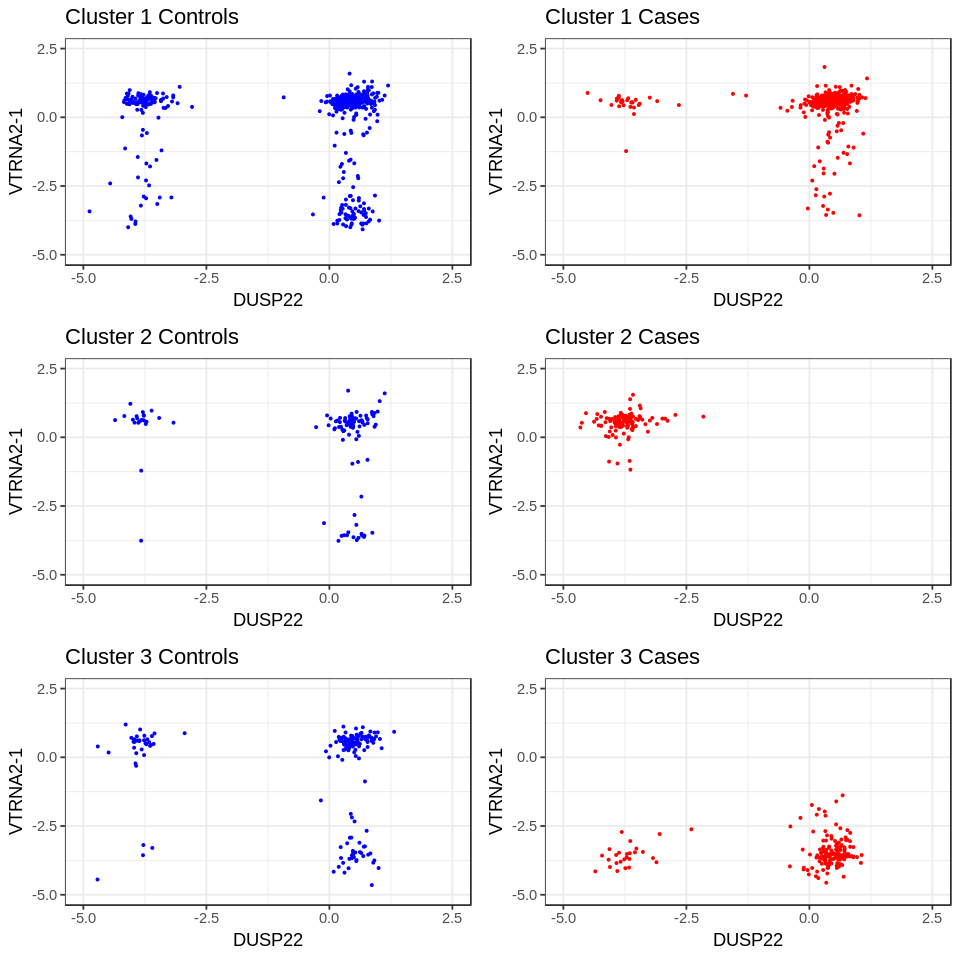

In [88]:
grid.arrange(g0_1,g1_1,g0_2,g1_2,g0_3,g1_3, ncol=2,nrow=3)

<a href='#TOC'>Go to TOC</a>
<a id='plot6'></a>

# we did the same analysis starting with Controls
<a id='plot7'></a>

[1]  863 2210

DBSCAN clustering for 863 objects.
Parameters: eps = 1.6, minPts = 15
The clustering contains 5 cluster(s) and 256 noise points.

  0   1   2   3   4   5 
256 345 103 104  39  16 

Available fields: cluster, eps, minPts

V1,V2,cluster,ID
13.972906,0.379845,0,PC_Pair_1
3.710935,-5.793976,0,PC_Pair_2
-2.693923,1.677066,1,PC_Pair_3
-2.053527,8.117369,1,PC_Pair_4
2.078947,11.471818,0,PC_Pair_5
-1.538436,6.915664,1,PC_Pair_6


[1] "Running PLS  Feature selection algorithm for C1"
pls variable importance

  only 20 most important variables shown (out of 145)

             Overall
DUSP22        100.00
VTRNA2.1       98.15
CYP4V2         27.93
LOC440910      24.97
LDHC           23.81
CCDC144NL      22.77
DOC2GP         22.38
LY6G5C         21.31
SIM2           20.52
LOC100128885   20.16
RIMS4          19.89
PSCA           19.17
CABLES1        18.49
C2orf69        17.87
C17orf98       17.67
IZUMO2         17.62
GSTM5          17.59
CTBP1.AS2      17.18
LOC100506159   16.69
FGF12          16.68
[1] "Running PLS  Feature selection algorithm for C2"
pls variable importance

  only 20 most important variables shown (out of 145)

                  Overall
DUSP22             100.00
VTRNA2.1            30.71
LCLAT1              18.51
C4B.C4B_2           17.86
RIMS4               17.23
HCG4B               16.72
LOC440910           15.34
GSTM5               14.52
PARD6G.PARD6G.AS1   14.19
PARD6G              14.19
PSORS

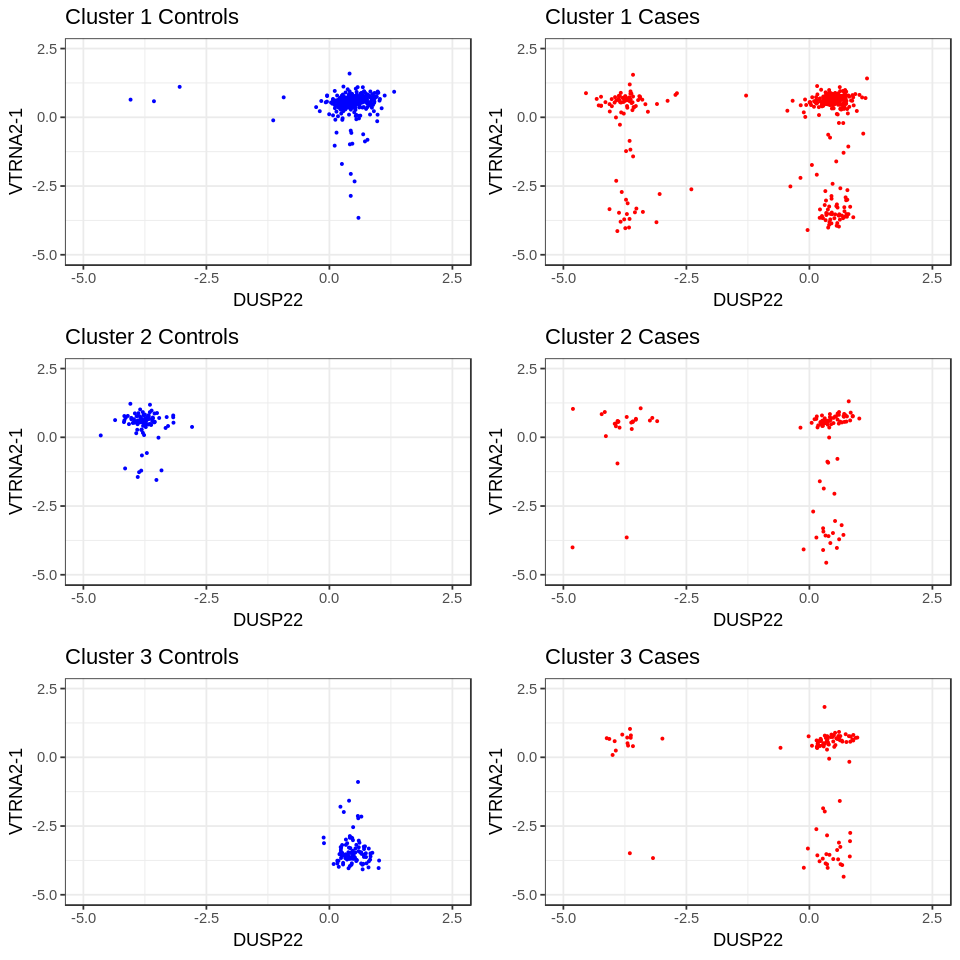

In [91]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='PC' & mccs_ess$CaseControl==1,]
cancer_control <- mccs_ess[mccs_ess$CancerCellType=="PC" & mccs_ess$CaseControl==0,]
cancer_cases_methy<- cancer_control[,ess_siv_probs$CG]#do the clustering based on controls

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)
res <- dbscan::dbscan(d_tsne_3,eps = 1.6, minPts = 15)
#plot(d_tsne_3, col=res$cluster, pch = 20,main="DBSCAN Extraction of PC Controls")
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res
d_tsne_3$cluster <- res$cluster
d_tsne_3$ID <- cancer_cases$ID
head(d_tsne_3) 
tsne_model_cluster1 <- d_tsne_3[d_tsne_3$cluster==1,]
tsne_model_cluster2 <- d_tsne_3[d_tsne_3$cluster==2,]
tsne_model_cluster3 <- d_tsne_3[d_tsne_3$cluster==3,]
cancer_cases_controls_avg <- read.csv("/data/gunaseka/ESS_MCCS_Analysis/averaged_accros_cluster.csv")

cancer_cases_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==1,]
cancer_controls_avg <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC" & cancer_cases_controls_avg$CaseControl==0,]
cluster1_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster1$ID, ]
cluster2_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster2$ID, ]
cluster3_cases <- cancer_cases_avg[cancer_cases_avg$ID %in% tsne_model_cluster3$ID, ]

cluster1_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster1$ID,]
cluster2_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster2$ID,]
cluster3_controls <- cancer_controls_avg[cancer_controls_avg$ID %in% tsne_model_cluster3$ID,]
cluster1_data <- rbind(cluster1_cases,cluster1_controls)
cluster1_data <- subset(cluster1_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster1_data$CaseControl <- as.factor(cluster1_data$CaseControl)


cluster2_data <- rbind(cluster2_cases,cluster2_controls)
cluster2_data <- subset(cluster2_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster2_data$CaseControl <- as.factor(cluster2_data$CaseControl)


cluster3_data <- rbind(cluster3_cases,cluster3_controls)
cluster3_data <- subset(cluster3_data,select = -c(Sample,ID,CancerCellType,AlcoholAmount,Smoking,bcell,bmi_rrto,cd4t,cd8t,gran,mono,nk))
cluster3_data$CaseControl <- as.factor(cluster3_data$CaseControl)

cluster1_data$cluster <- rep("C1",dim(cluster1_data)[1])
cluster2_data$cluster <- rep("C2",dim(cluster2_data)[1])
cluster3_data$cluster <- rep("C3",dim(cluster3_data)[1])

for (cluster_id in c("C1","C2","C3")){
    print(paste0("Running PLS  Feature selection algorithm for ",cluster_id))
    df <- all_cluster_data[all_cluster_data$cluster==cluster_id,]
    df$CaseControl <- as.factor(df$CaseContro)
    df$cluster <- NULL
    myfolds <- createMultiFolds(df$CaseControl, k = 5, times = 10)
    control <- trainControl("repeatedcv", index = myfolds, selectionFunction = "oneSE")

    # Train PLS model
    mod1 <- train(CaseControl ~ ., data = df,
     method = "pls",
     metric = "Accuracy",
     tuneLength = 20,
     trControl = control,
     preProc = c("zv","center","scale"))
    # Check CV profile
    #plot(mod1)
    print(varImp(mod1))

}

test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of  DUSP22 and VTRNA2-1 Methylation for Cluster 1") +
scale_colour_brewer(palette = "Set2")


test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_1 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_1 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 1 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)



test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of DUSP22 and VTRNA2-1 Methylation for Cluster 2") +
scale_colour_brewer(palette = "Set2")


test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_2 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_2 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 2 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)



test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
g <- ggplot(test_VT_DUSP, aes(x=DUSP22, y=VTRNA2.1,colour = CaseControl)) +
geom_point(size=0.45) +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Scatter plot of DUSP22 and VTRNA2-1 Methylation for Cluster 3") +
scale_colour_brewer(palette = "Set2")

test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
test_VT_DUSP_1 <- test_VT_DUSP[test_VT_DUSP$CaseControl==1,]
test_VT_DUSP_0 <- test_VT_DUSP[test_VT_DUSP$CaseControl==0,]

g0_3 <- ggplot(test_VT_DUSP_0, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="blue") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Controls") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

g1_3 <- ggplot(test_VT_DUSP_1, aes(x=DUSP22, y=VTRNA2.1)) +
geom_point(size=0.45,color="red") +
guides(colour=guide_legend(override.aes=list(size=6))) +
xlab("DUSP22") + ylab("VTRNA2-1") +theme_bw()+
ggtitle("Cluster 3 Cases") +
scale_colour_brewer(palette = "Set2")+xlim(-5, 2.5)+ylim(-5, 2.5)

grid.arrange(g0_1,g1_1,g0_2,g1_2,g0_3,g1_3, ncol=2,nrow=3)

<a href='#TOC'>Go to TOC</a>

## Conditional Logistic Regression with DUSP22 and VTRNA2-1 Interaction Term

In [96]:
library(survival)
print("----------------------------------------PC case and Controls----------------------------------------")
cancer_cases_controls_avg_PC <- cancer_cases_controls_avg[cancer_cases_controls_avg$CancerCellType=="PC",]
dataset1 <- cancer_cases_controls_avg_PC[c("CaseControl","ID","VTRNA2.1","DUSP22")]
res.clogit <- clogit(CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22 + strata(ID), dataset1)
summary(res.clogit)

print("----------------------------------------Cluster 1 PC case and Controls----------------------------------------")
test_VT_DUSP <- cluster1_data[c("DUSP22","CaseControl","VTRNA2.1")]
res.logit1 <- glm(CaseControl ~ VTRNA2.1 +DUSP22+ VTRNA2.1:DUSP22, test_VT_DUSP, family = binomial(link = "logit"))
summary(res.logit1)

print("----------------------------------------Cluster 2 PC case and Controls-----------------------------------------")
test_VT_DUSP <- cluster2_data[c("DUSP22","CaseControl","VTRNA2.1")]
res.logit1 <- glm(CaseControl ~ VTRNA2.1 +DUSP22+ VTRNA2.1:DUSP22, test_VT_DUSP, family = binomial(link = "logit"))
summary(res.logit1)

print("---------------------------------------Cluster 3 PC case and Controls-------------------------------------------")
test_VT_DUSP <- cluster3_data[c("DUSP22","CaseControl","VTRNA2.1")]
res.logit1 <- glm(CaseControl ~ VTRNA2.1 +DUSP22+ VTRNA2.1:DUSP22, test_VT_DUSP, family = binomial(link = "logit"))
summary(res.logit1)

[1] "----------------------------------------PC case and Controls----------------------------------------"


Call:
coxph(formula = Surv(rep(1, 1726L), CaseControl) ~ VTRNA2.1 + 
    DUSP22 + VTRNA2.1:DUSP22 + strata(ID), data = dataset1, method = "exact")

  n= 1726, number of events= 863 

                     coef exp(coef)  se(coef)      z Pr(>|z|)  
VTRNA2.1        -0.056093  0.945452  0.030729 -1.825   0.0679 .
DUSP22          -0.009023  0.991018  0.026515 -0.340   0.7336  
VTRNA2.1:DUSP22  0.011601  1.011668  0.017675  0.656   0.5116  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                exp(coef) exp(-coef) lower .95 upper .95
VTRNA2.1           0.9455     1.0577    0.8902     1.004
DUSP22             0.9910     1.0091    0.9408     1.044
VTRNA2.1:DUSP22    1.0117     0.9885    0.9772     1.047

Rsquare= 0.003   (max possible= 0.5 )
Likelihood ratio test= 4.74  on 3 df,   p=0.2
Wald test            = 4.68  on 3 df,   p=0.2
Score (logrank) test = 4.72  on 3 df,   p=0.2


[1] "----------------------------------------Cluster 1 PC case and Controls----------------------------------------"



Call:
glm(formula = CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22, 
    family = binomial(link = "logit"), data = test_VT_DUSP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4301  -0.9744  -0.2993   1.2808   1.8973  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      0.22843    0.10825   2.110   0.0348 *  
VTRNA2.1        -0.67693    0.12375  -5.470 4.50e-08 ***
DUSP22          -0.77518    0.14109  -5.494 3.93e-08 ***
VTRNA2.1:DUSP22  0.01034    0.16713   0.062   0.9507    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 956.54  on 689  degrees of freedom
Residual deviance: 778.51  on 686  degrees of freedom
AIC: 786.51

Number of Fisher Scoring iterations: 7


[1] "----------------------------------------Cluster 2 PC case and Controls-----------------------------------------"



Call:
glm(formula = CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22, 
    family = binomial(link = "logit"), data = test_VT_DUSP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1814  -0.6255  -0.1536   0.1352   2.6264  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.17653    1.07454   3.887 0.000102 ***
VTRNA2.1        -0.08998    0.64406  -0.140 0.888889    
DUSP22           1.43452    0.29237   4.907 9.27e-07 ***
VTRNA2.1:DUSP22  0.12223    0.16897   0.723 0.469429    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 285.58  on 205  degrees of freedom
Residual deviance: 129.44  on 202  degrees of freedom
AIC: 137.44

Number of Fisher Scoring iterations: 7


[1] "---------------------------------------Cluster 3 PC case and Controls-------------------------------------------"



Call:
glm(formula = CaseControl ~ VTRNA2.1 + DUSP22 + VTRNA2.1:DUSP22, 
    family = binomial(link = "logit"), data = test_VT_DUSP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8406  -0.6188  -0.1401   0.2623   2.4096  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)       3.0124     0.6997   4.305 1.67e-05 ***
VTRNA2.1          1.1376     0.2230   5.101 3.38e-07 ***
DUSP22           -0.7435     1.0554  -0.704    0.481    
VTRNA2.1:DUSP22   0.1328     0.3432   0.387    0.699    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 288.35  on 207  degrees of freedom
Residual deviance: 141.99  on 204  degrees of freedom
AIC: 149.99

Number of Fisher Scoring iterations: 8


## 2. Breast Cancer Cases
<a href='#TOC'>Go to TOC</a>
<a id='plot8'></a>

[1]  433 2210

[1]  433 1607

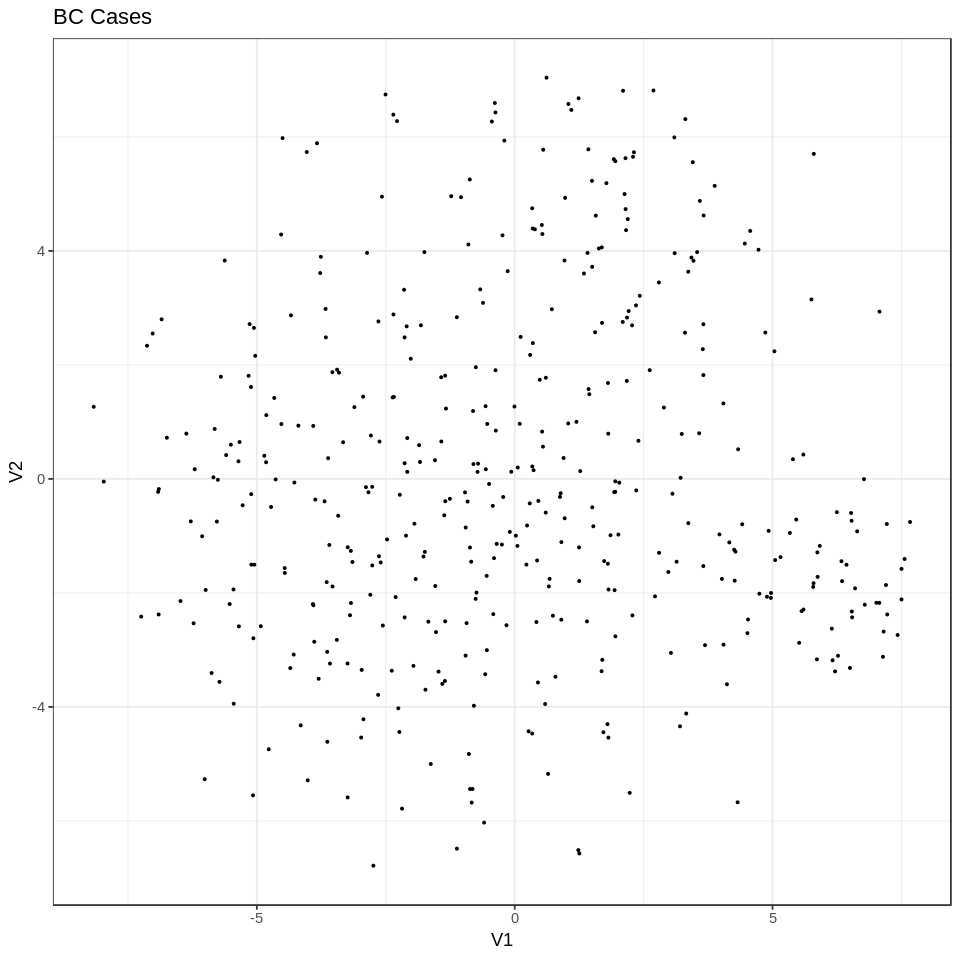

DBSCAN clustering for 433 objects.
Parameters: eps = 1.2, minPts = 15
The clustering contains 3 cluster(s) and 96 noise points.

  0   1   2   3 
 96 222  61  54 

Available fields: cluster, eps, minPts

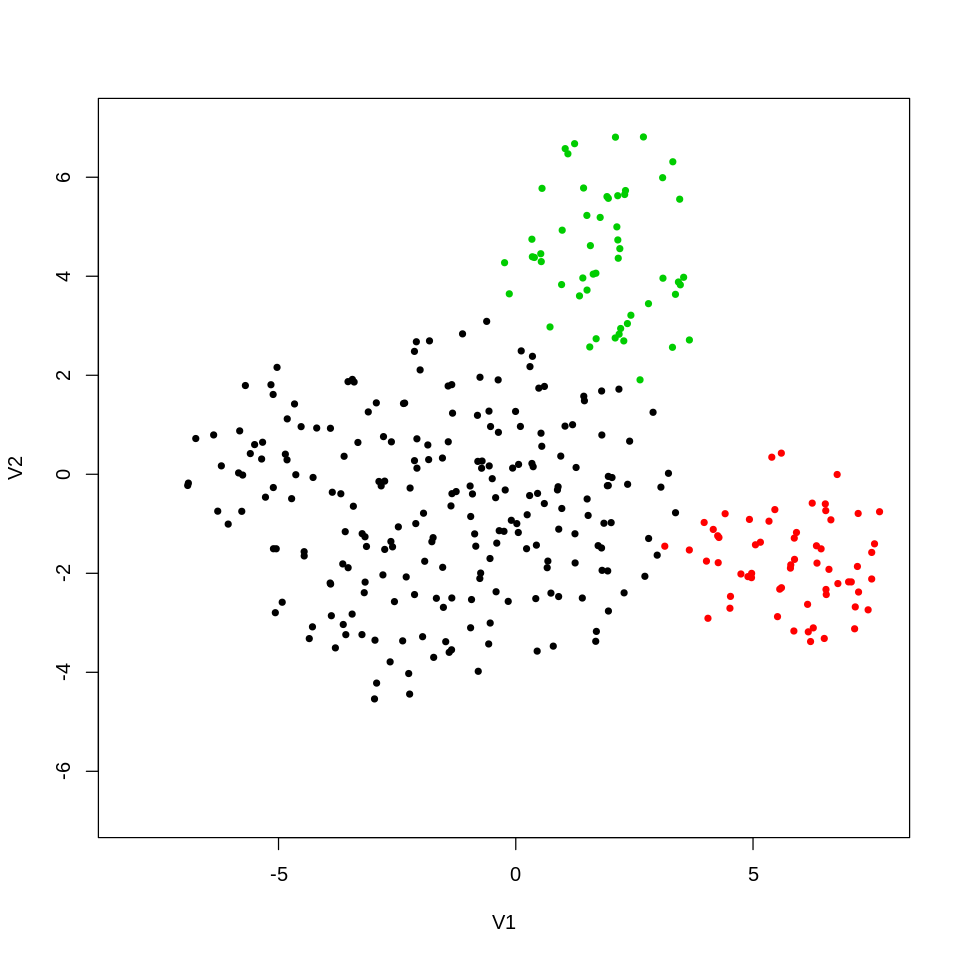

In [98]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='BC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("BC Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.2, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

# CRC cases
<a href='#TOC'>Go to TOC</a>
<a id='plot9'></a>

[1]  834 2210

[1]  834 1683

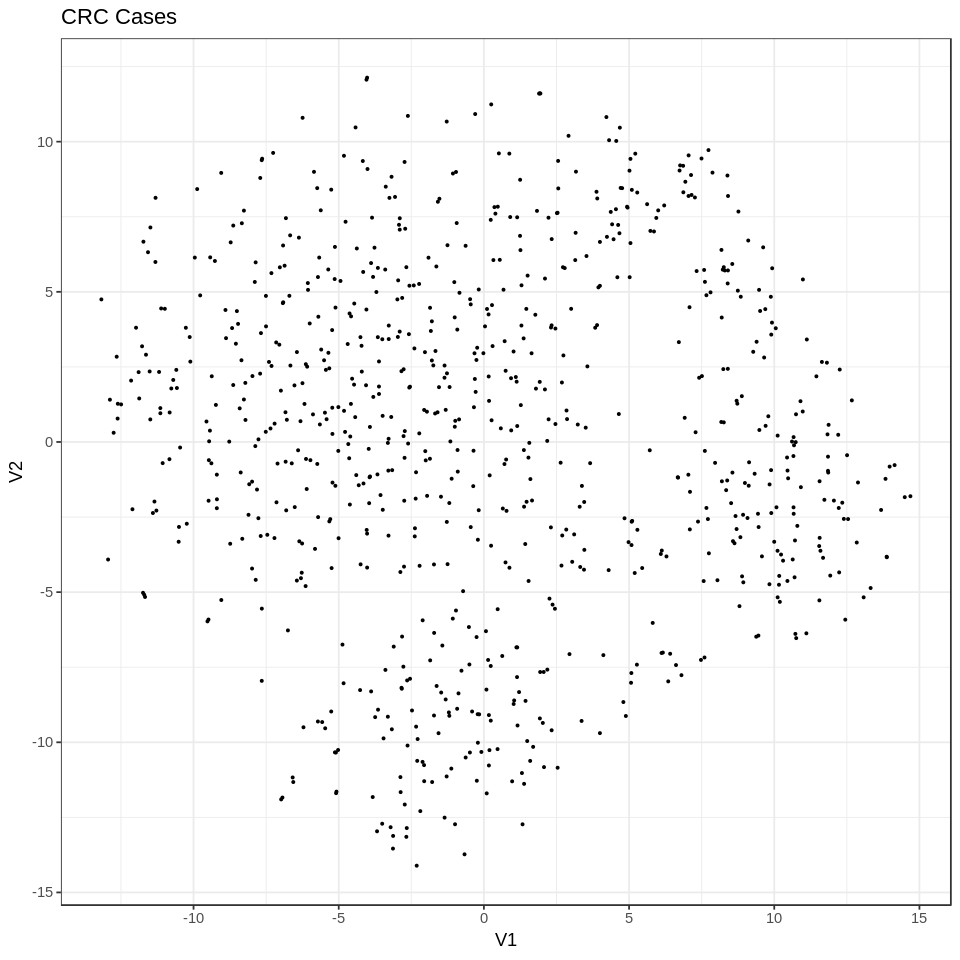

DBSCAN clustering for 834 objects.
Parameters: eps = 1.3, minPts = 15
The clustering contains 5 cluster(s) and 390 noise points.

  0   1   2   3   4   5 
390 235  44  59  84  22 

Available fields: cluster, eps, minPts

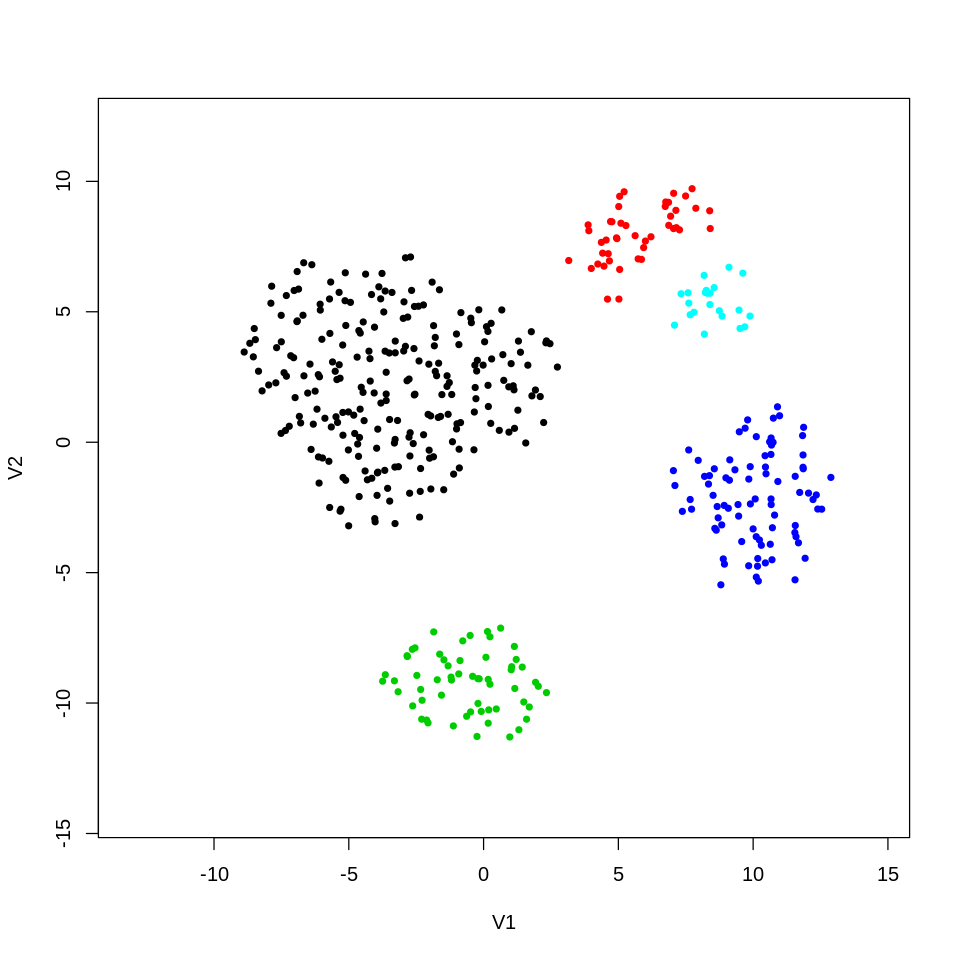

In [99]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='CRC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("CRC Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.3, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

# Lung Cases
<a href='#TOC'>Go to TOC</a>
<a id='plot10'></a>

[1]  331 2210

[1]  331 1955

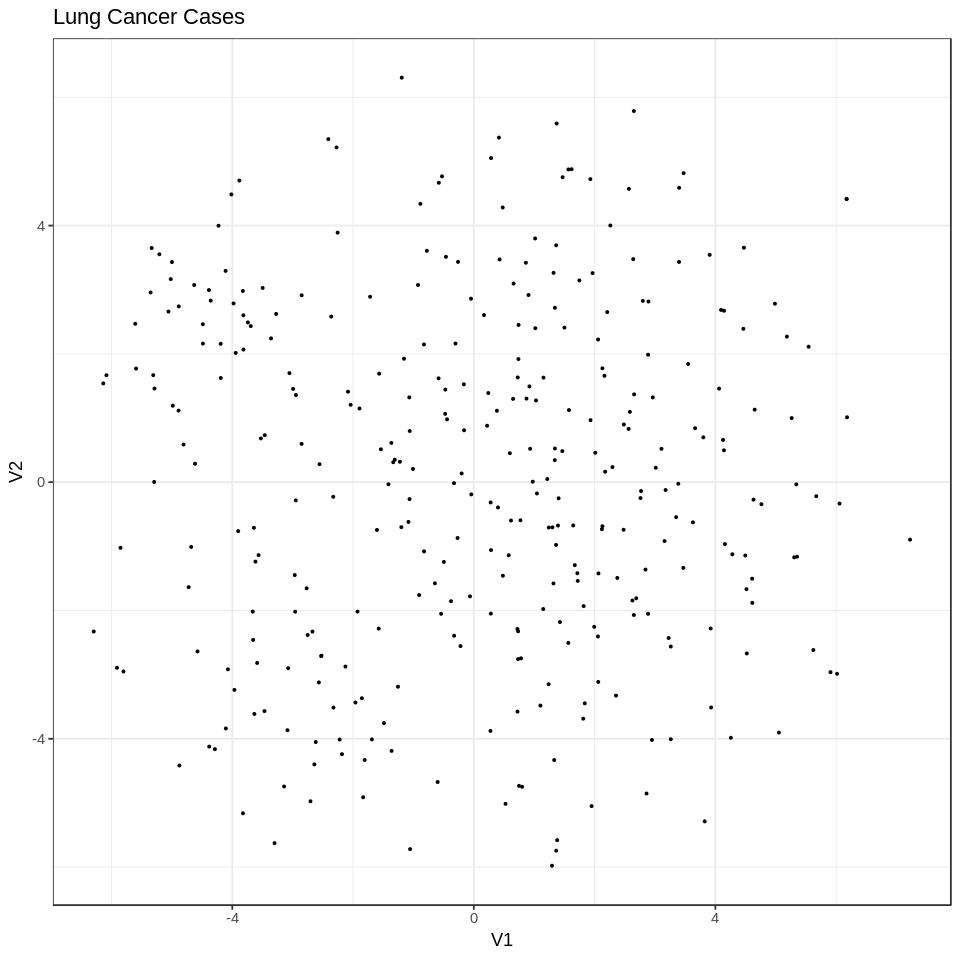

DBSCAN clustering for 331 objects.
Parameters: eps = 1.1, minPts = 15
The clustering contains 3 cluster(s) and 106 noise points.

  0   1   2   3 
106 153  36  36 

Available fields: cluster, eps, minPts

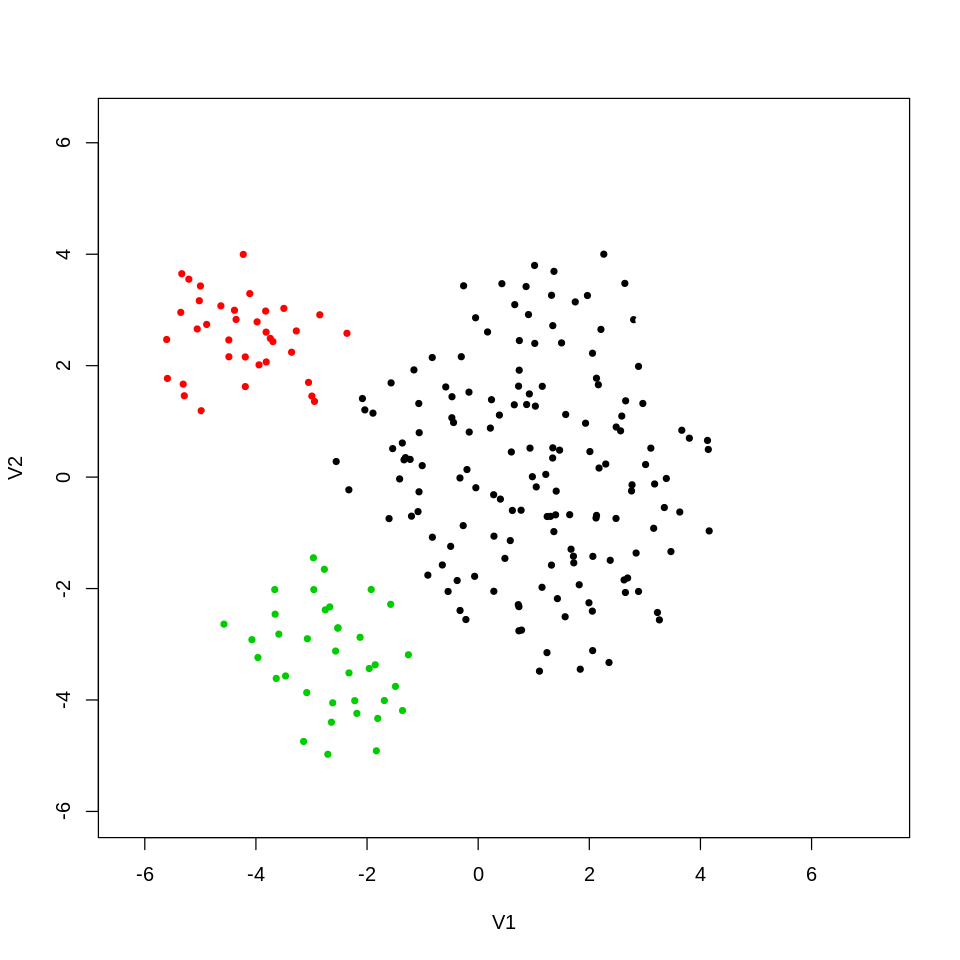

In [108]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='Lung' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("Lung Cancer Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.1, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

<a href='#TOC'>Go to TOC</a>
<a id='plot11'></a>

[1]  435 2210

[1]  435 1871

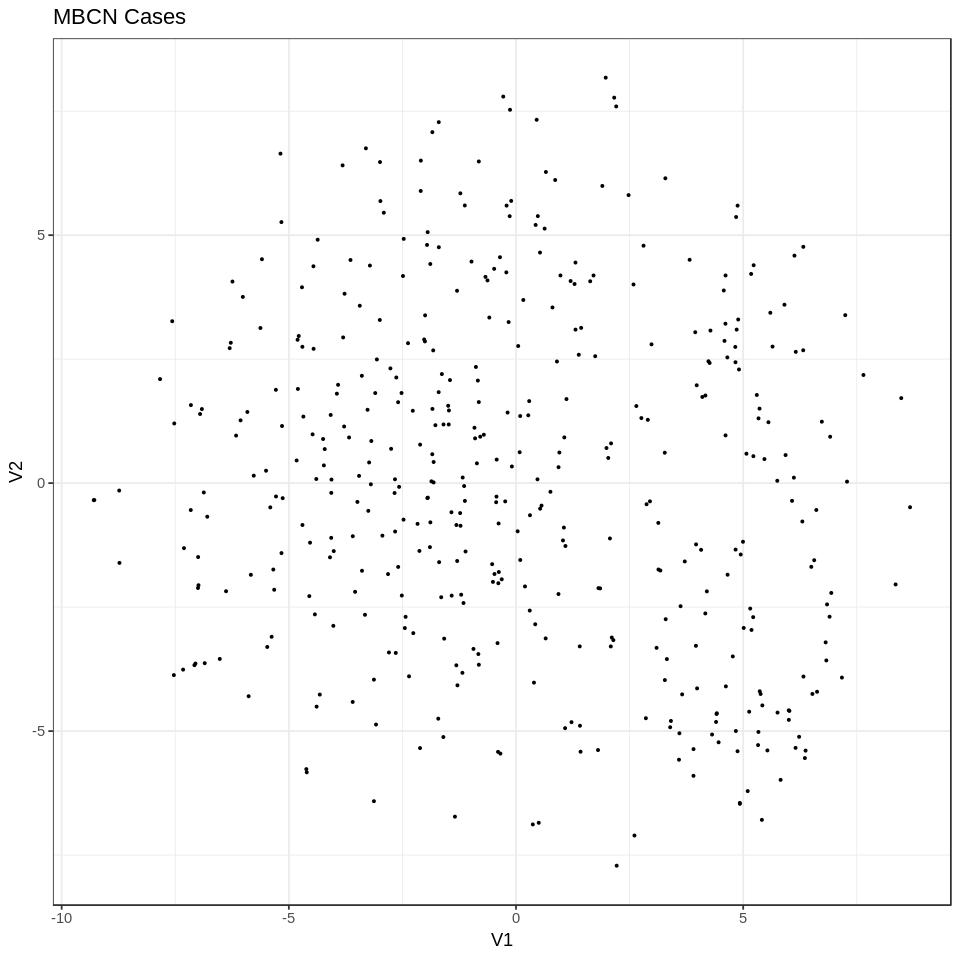

DBSCAN clustering for 435 objects.
Parameters: eps = 1.1, minPts = 15
The clustering contains 3 cluster(s) and 231 noise points.

  0   1   2   3 
231 136  44  24 

Available fields: cluster, eps, minPts

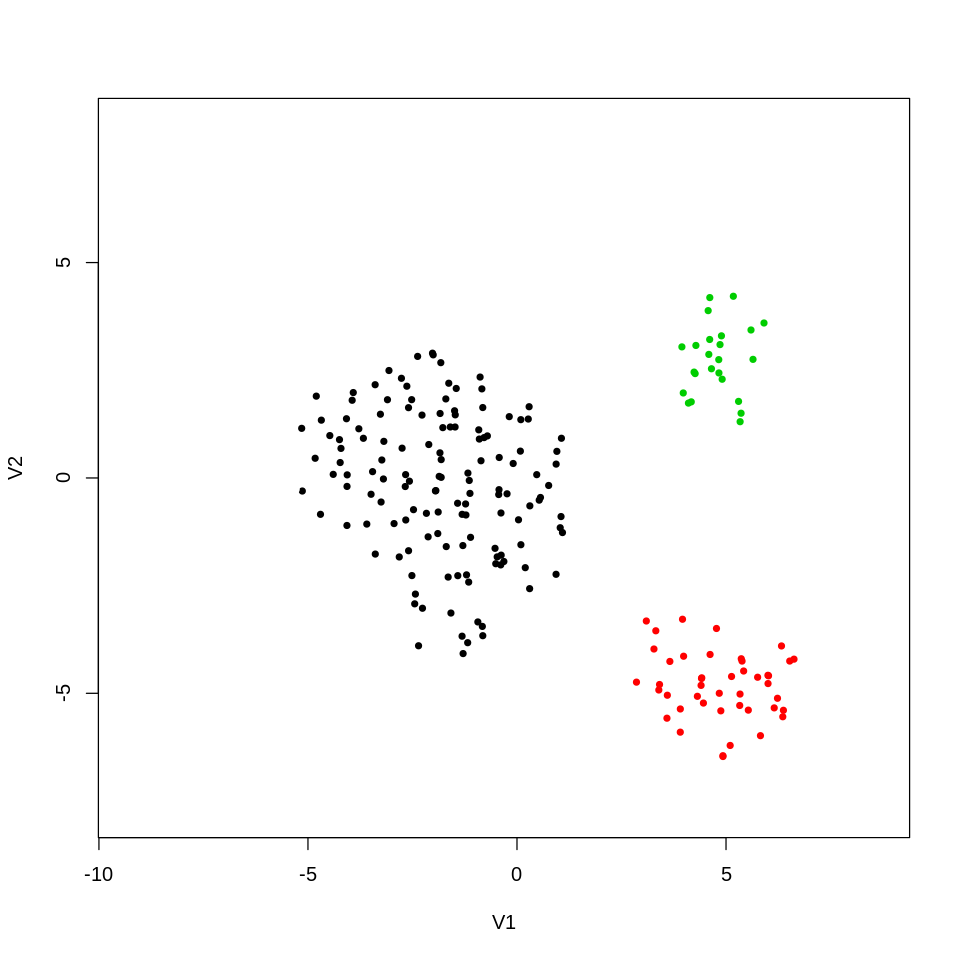

In [100]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='MBCN' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("MBCN Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.1, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

<a href='#TOC'>Go to TOC</a>
<a id='plot12'></a>

[1]  426 2210

[1]  426 1961

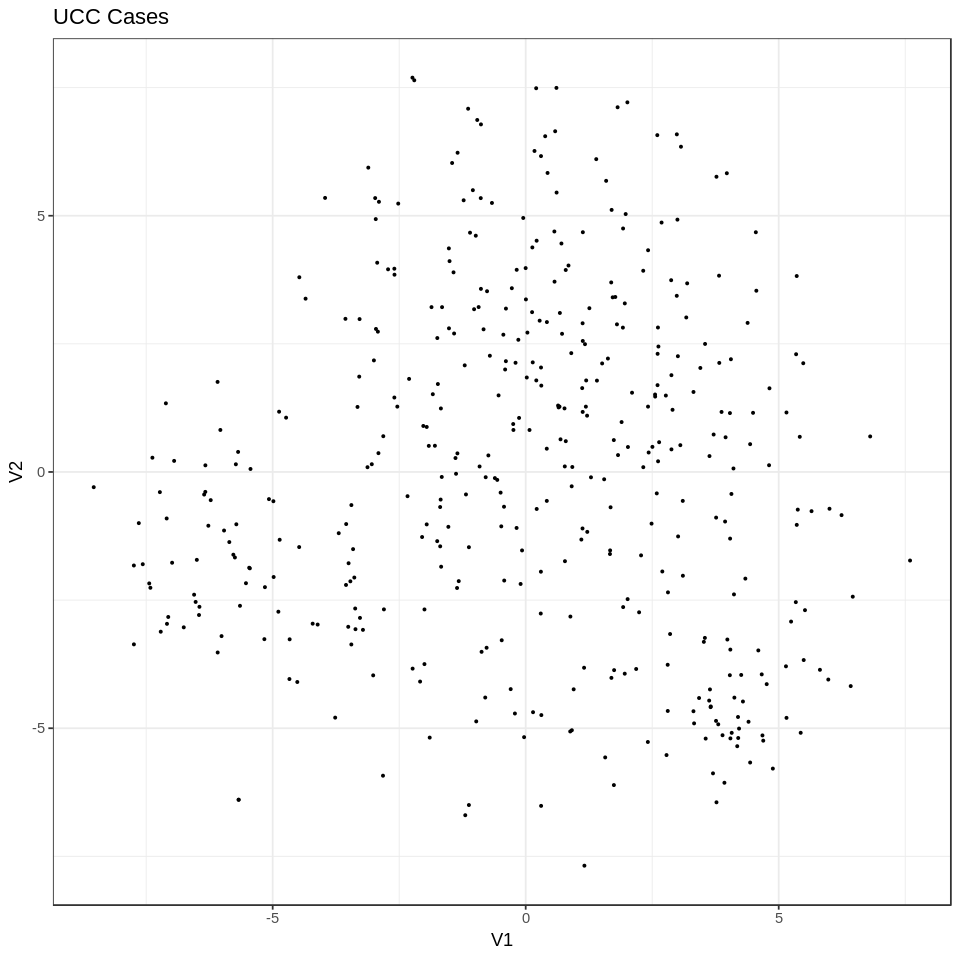

DBSCAN clustering for 426 objects.
Parameters: eps = 1.1, minPts = 15
The clustering contains 3 cluster(s) and 170 noise points.

  0   1   2   3 
170 173  37  46 

Available fields: cluster, eps, minPts

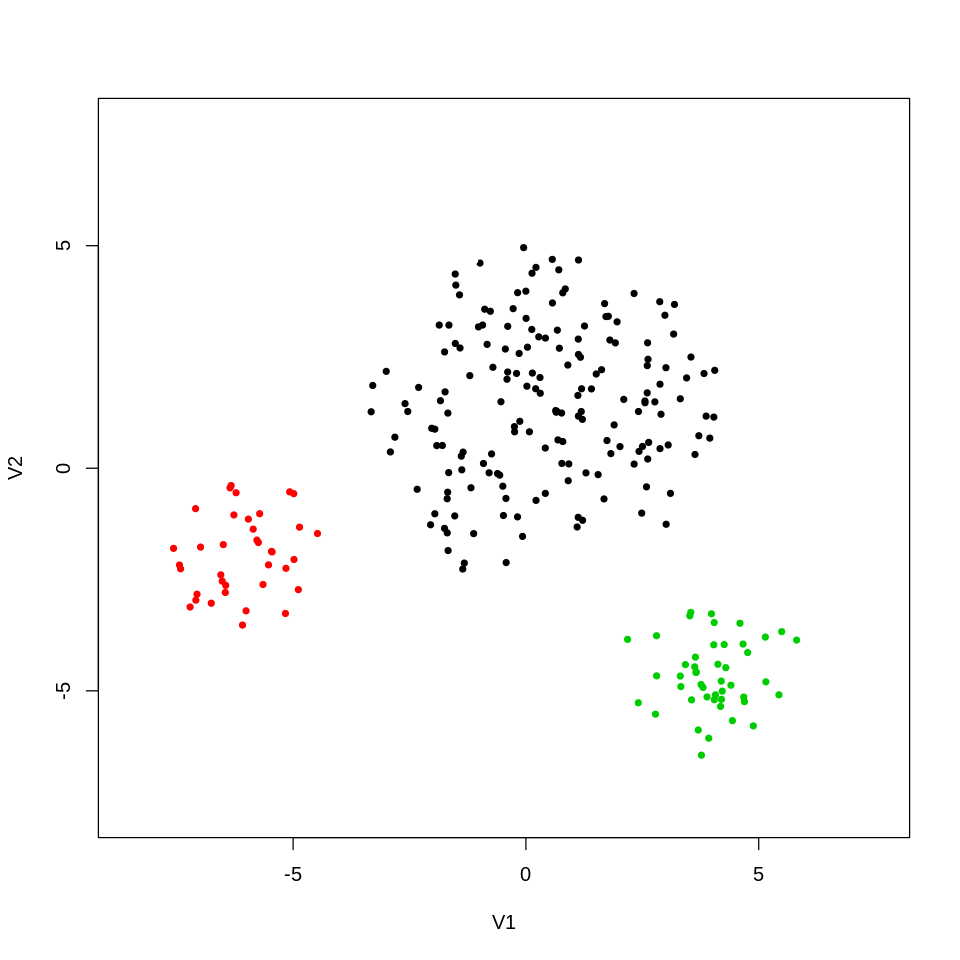

In [101]:
cancer_cases <- mccs_ess[mccs_ess$CancerCellType=='UCC' & mccs_ess$CaseControl==1,]
cancer_cases_methy<- cancer_cases[,ess_siv_probs$CG]

dim(cancer_cases_methy)
nums <- unlist(lapply(cancer_cases_methy, is.numeric))
cancer_cases_methy <- cancer_cases_methy[,nums]
cancer_cases_methy <- cancer_cases_methy[ , colSums(is.na(cancer_cases_methy)) == 0]
dim(cancer_cases_methy)

set.seed(9)
tsne_model_3 = Rtsne(as.matrix(cancer_cases_methy), check_duplicates=T, pca=T, perplexity=30, theta=0.5, dims=2)
d_tsne_3 = as.data.frame(tsne_model_3$Y)

ggplot(d_tsne_3, aes(x=V1, y=V2)) +
  geom_point(size=0.45) +
  guides(colour=guide_legend(override.aes=list(size=6))) +
  xlab("V1") + ylab("V2") +theme_bw()+
  ggtitle("UCC Cases") +
  scale_colour_brewer(palette = "Set2")

res <- dbscan::dbscan(d_tsne_3,eps = 1.1, minPts = 15)
plot(d_tsne_3, col=res$cluster, pch = 20)
#points(d_tsne_1[res$cluster == 0L], col = "grey", pch = "+")
res

<a href='#TOC'>Go to TOC</a>
<a id='plot12'></a>